In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from bs4 import BeautifulSoup
import cv2
import random as rand


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes = np.array(boxes)
        labels = np.array(labels)
        img_id = np.array(image_id)
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id

        
        return (target,num_objs)


In [4]:
data_dir="C:/Users/srira/Documents/Python/ImageClassification/NewCNN/MaskPascalVOC"
imgs_dir=os.path.join(data_dir,"images")
labels_dir=os.path.join(data_dir,"annotations")

imgs = list(sorted(os.listdir(imgs_dir)))
labels = list(sorted(os.listdir(labels_dir)))


In [5]:

targets=[]
numobjs=[]

for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join(imgs_dir, file_image)
    label_path = os.path.join(labels_dir, file_label)
    
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [6]:
face_images=[]
face_labels=[]
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    img_path = os.path.join(imgs_dir, file_image)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
        #get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
        #Get the face from the image using the coordinates
        #the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
          
        img1 = preprocess_input(img1)
          
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [7]:
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)


In [8]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [9]:
baseModel = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet")

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [13]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [14]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
    test_size=0.2, stratify=labels, random_state=42)


In [15]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)
    #class_weight = {0:5 , 1:1, 2:10}

Epoch 1/10
101/101 [==============================] - 47s 465ms/step - loss: 0.5157 - accuracy: 0.8198 - val_loss: 0.3610 - val_accuracy: 0.8883
Epoch 2/10
101/101 [==============================] - 36s 359ms/step - loss: 0.3627 - accuracy: 0.8688 - val_loss: 0.3104 - val_accuracy: 0.8957
Epoch 3/10
101/101 [==============================] - 37s 363ms/step - loss: 0.3282 - accuracy: 0.8878 - val_loss: 0.2840 - val_accuracy: 0.9067
Epoch 4/10
101/101 [==============================] - 36s 361ms/step - loss: 0.2984 - accuracy: 0.8943 - val_loss: 0.2708 - val_accuracy: 0.9055
Epoch 5/10
101/101 [==============================] - 37s 362ms/step - loss: 0.2889 - accuracy: 0.9033 - val_loss: 0.2457 - val_accuracy: 0.9153
Epoch 6/10
101/101 [==============================] - 37s 362ms/step - loss: 0.2681 - accuracy: 0.9033 - val_loss: 0.2430 - val_accuracy: 0.9092
Epoch 7/10
101/101 [==============================] - 37s 363ms/step - loss: 0.2677 - accuracy: 0.9119 - val_loss: 0.2462 - val_ac

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       143
           1       0.94      0.97      0.95       647
           2       0.73      0.32      0.44        25

    accuracy                           0.93       815
   macro avg       0.85      0.71      0.75       815
weighted avg       0.92      0.93      0.92       815



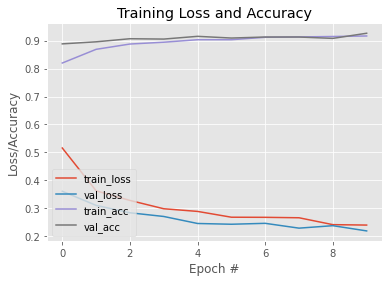

In [16]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
    ))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [24]:
model.save('imagenet_model.h5')

In [3]:
model = tf.keras.models.load_model('imagenet_model.h5')

In [28]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
101/101 [==============================] - 39s 384ms/step - loss: 0.2320 - accuracy: 0.9153 - val_loss: 0.2320 - val_accuracy: 0.9141
Epoch 2/10
101/101 [==============================] - 39s 386ms/step - loss: 0.2336 - accuracy: 0.9212 - val_loss: 0.2176 - val_accuracy: 0.9288
Epoch 3/10
101/101 [==============================] - 37s 363ms/step - loss: 0.2158 - accuracy: 0.9281 - val_loss: 0.2286 - val_accuracy: 0.9202
Epoch 4/10
101/101 [==============================] - 37s 366ms/step - loss: 0.2232 - accuracy: 0.9178 - val_loss: 0.2105 - val_accuracy: 0.9276
Epoch 5/10
101/101 [==============================] - 37s 369ms/step - loss: 0.2224 - accuracy: 0.9271 - val_loss: 0.2064 - val_accuracy: 0.9276
Epoch 6/10
101/101 [==============================] - 38s 374ms/step - loss: 0.2121 - accuracy: 0.9262 - val_loss: 0.2130 - val_accuracy: 0.9227
Epoch 7/10
101/101 [==============================] - 37s 368ms/step - loss: 0.2

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       143
           1       0.95      0.97      0.96       647
           2       0.67      0.32      0.43        25

    accuracy                           0.93       815
   macro avg       0.83      0.73      0.76       815
weighted avg       0.93      0.93      0.93       815



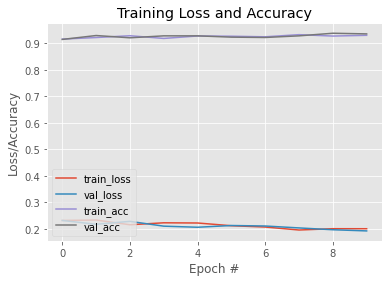

In [29]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()